In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [4]:
#Specify paths here
root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/both"
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/processed_data.csv')

In [6]:
#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    shape = (76, 33)
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (shape):
                      continue
                    image_array = normalize(image_array)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds



data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
print(input_shape)

100%|██████████| 837/837 [00:14<00:00, 59.29it/s] 

(873, 76, 33, 3)


In [7]:
print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 76, 33, 3)
(76, 33, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.58492, saving model to model.h5
61/61 - 29s - loss: 1.8547 - accuracy: 0.4591 - val_loss: 2.5849 - val_accuracy: 0.3471 - lr: 0.0010 - 29s/epoch - 468ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.58492 to 1.72700, saving model to model.h5
61/61 - 4s - loss: 1.3061 - accuracy: 0.5795 - val_loss: 1.7270 - val_accuracy: 0.4765 - lr: 0.0010 - 4s/epoch - 66ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.72700 to 1.47019, saving model to model.h5
61/61 - 3s - loss: 1.1507 - accuracy: 0.6226 - val_loss: 1.4702 - val_accuracy: 0.5521 - lr: 0.0010 - 3s/epoch - 56ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.47019 to 1.37356, saving model to model.h5
61/61 - 3s - loss: 1.0324 - accuracy: 0.6557 - val_loss: 1.3736 - val_accuracy: 0.5395 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.37356
61/61 - 2s - loss: 0.9511 - accuracy: 0.6843 - val_loss: 1.

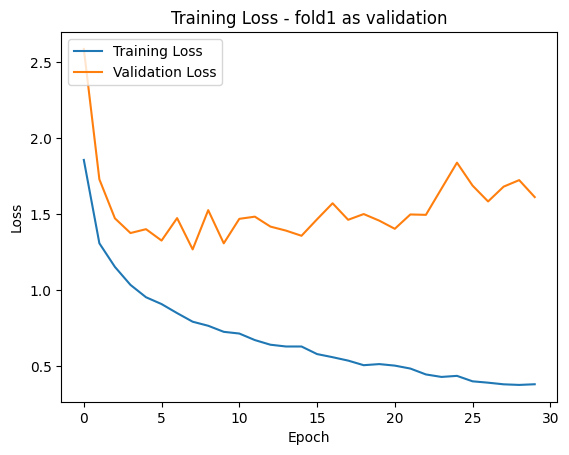

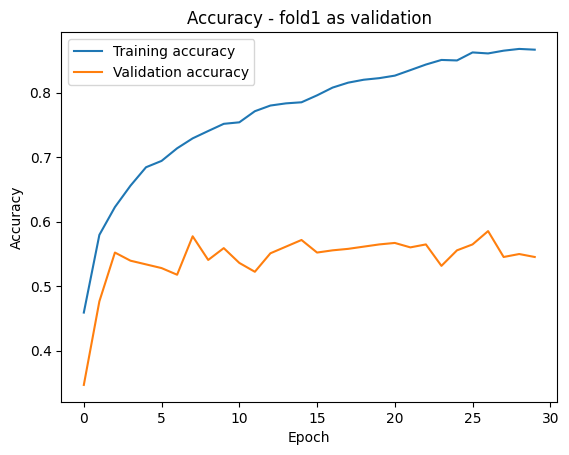

 10%|█         | 1/10 [02:55<26:17, 175.27s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.35760, saving model to model.h5
61/61 - 16s - loss: 1.8167 - accuracy: 0.4595 - val_loss: 2.3576 - val_accuracy: 0.3074 - lr: 0.0010 - 16s/epoch - 267ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.35760 to 1.66792, saving model to model.h5
61/61 - 4s - loss: 1.2907 - accuracy: 0.5824 - val_loss: 1.6679 - val_accuracy: 0.4459 - lr: 0.0010 - 4s/epoch - 63ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.66792 to 1.56559, saving model to model.h5
61/61 - 3s - loss: 1.1524 - accuracy: 0.6330 - val_loss: 1.5656 - val_accuracy: 0.5056 - lr: 0.0010 - 3s/epoch - 55ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.56559
61/61 - 2s - loss: 1.0241 - accuracy: 0.6656 - val_loss: 1.5786 - val_accuracy: 0.5045 - lr: 0.0010 - 2s/epoch - 40ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.56559 to 1.50981, saving model to model.h5
61/61 - 3s - loss: 0.9751 - accuracy: 0.6782 - val_loss: 1.

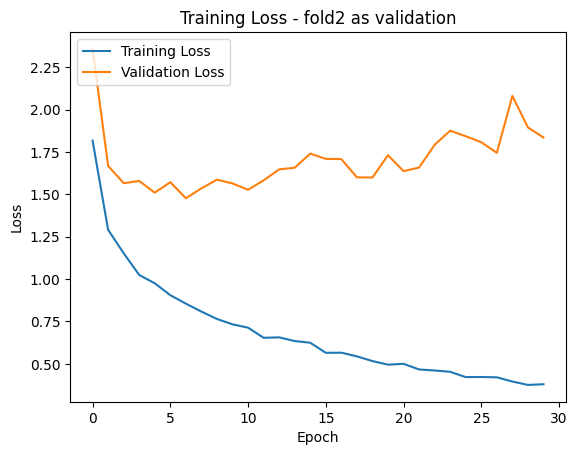

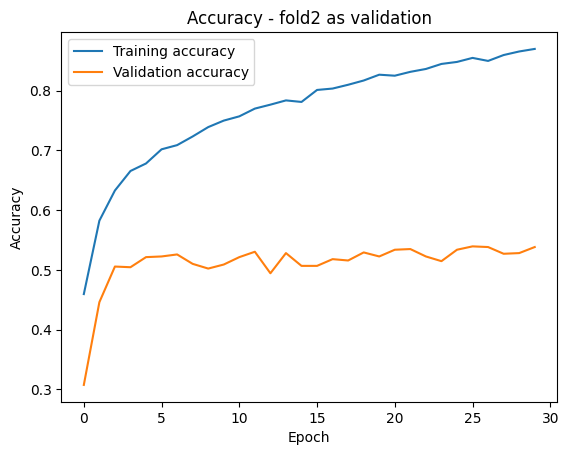

 20%|██        | 2/10 [04:39<17:46, 133.29s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.54054, saving model to model.h5
60/60 - 16s - loss: 1.7884 - accuracy: 0.4750 - val_loss: 2.5405 - val_accuracy: 0.3481 - lr: 0.0010 - 16s/epoch - 264ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.54054 to 1.77479, saving model to model.h5
60/60 - 7s - loss: 1.2807 - accuracy: 0.5943 - val_loss: 1.7748 - val_accuracy: 0.4227 - lr: 0.0010 - 7s/epoch - 118ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.77479 to 1.65189, saving model to model.h5
60/60 - 5s - loss: 1.1221 - accuracy: 0.6322 - val_loss: 1.6519 - val_accuracy: 0.4465 - lr: 0.0010 - 5s/epoch - 91ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.65189 to 1.63302, saving model to model.h5
60/60 - 3s - loss: 1.0128 - accuracy: 0.6733 - val_loss: 1.6330 - val_accuracy: 0.4443 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.63302 to 1.58639, saving model to model.h5
60/60 - 3s - loss: 0.9247 - 

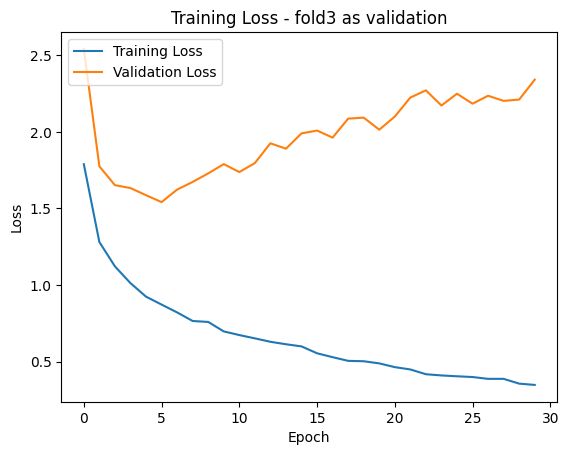

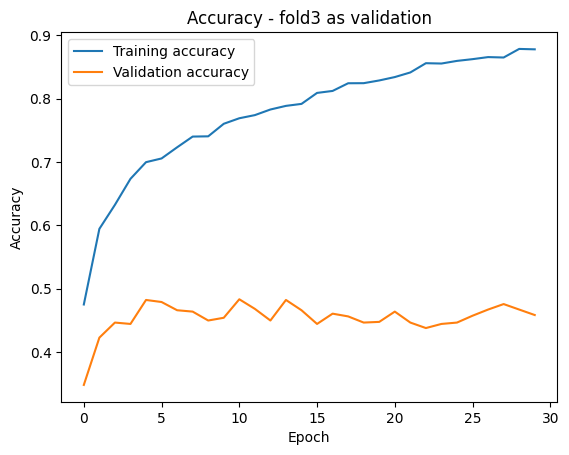

 30%|███       | 3/10 [07:22<17:10, 147.20s/it]

Training using fold4 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.71897, saving model to model.h5
60/60 - 16s - loss: 1.8223 - accuracy: 0.4667 - val_loss: 2.7190 - val_accuracy: 0.3343 - lr: 0.0010 - 16s/epoch - 268ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.71897 to 1.69897, saving model to model.h5
60/60 - 4s - loss: 1.2690 - accuracy: 0.5939 - val_loss: 1.6990 - val_accuracy: 0.4475 - lr: 0.0010 - 4s/epoch - 71ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.69897 to 1.53780, saving model to model.h5
60/60 - 3s - loss: 1.1118 - accuracy: 0.6357 - val_loss: 1.5378 - val_accuracy: 0.4788 - lr: 0.0010 - 3s/epoch - 48ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.53780
60/60 - 2s - loss: 1.0131 - accuracy: 0.6690 - val_loss: 1.5959 - val_accuracy: 0.4535 - lr: 0.0010 - 2s/epoch - 37ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.53780 to 1.50020, saving model to model.h5
60/60 - 3s - loss: 0.9395 - accuracy: 0.6872 - val_loss: 1.

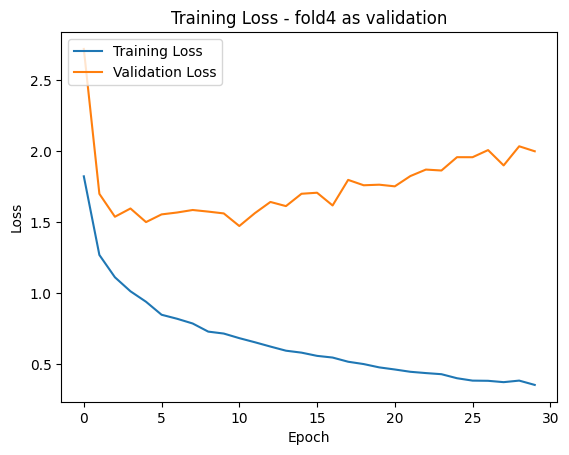

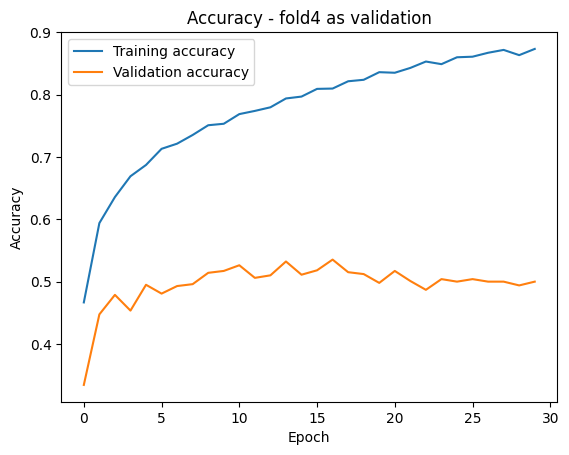

 40%|████      | 4/10 [09:06<12:59, 129.89s/it]

Training using fold5 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.32945, saving model to model.h5
60/60 - 17s - loss: 1.8384 - accuracy: 0.4660 - val_loss: 2.3295 - val_accuracy: 0.3558 - lr: 0.0010 - 17s/epoch - 282ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.32945 to 1.68861, saving model to model.h5
60/60 - 5s - loss: 1.2940 - accuracy: 0.5871 - val_loss: 1.6886 - val_accuracy: 0.4712 - lr: 0.0010 - 5s/epoch - 79ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.68861 to 1.39472, saving model to model.h5
60/60 - 3s - loss: 1.1403 - accuracy: 0.6281 - val_loss: 1.3947 - val_accuracy: 0.5310 - lr: 0.0010 - 3s/epoch - 53ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.39472 to 1.35017, saving model to model.h5
60/60 - 3s - loss: 1.0264 - accuracy: 0.6624 - val_loss: 1.3502 - val_accuracy: 0.4968 - lr: 0.0010 - 3s/epoch - 50ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.35017 to 1.29151, saving model to model.h5
60/60 - 3s - loss: 0.9740 - a

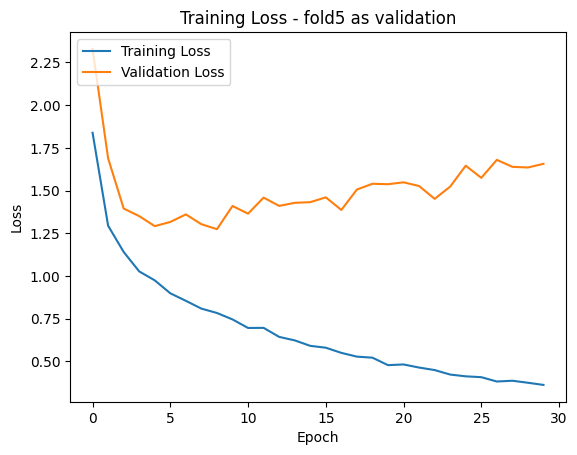

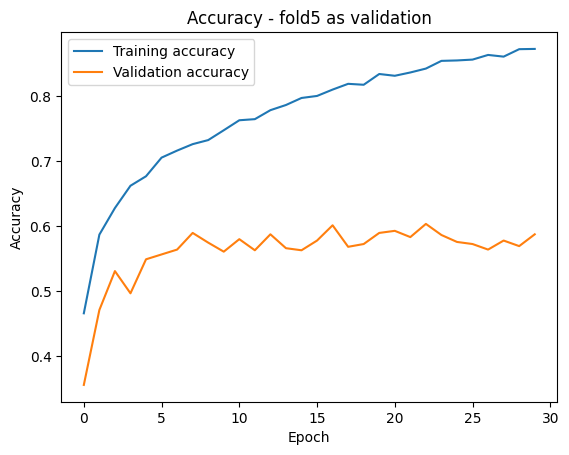

 50%|█████     | 5/10 [10:51<10:04, 120.96s/it]

Training using fold6 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.62889, saving model to model.h5
61/61 - 15s - loss: 1.8063 - accuracy: 0.4631 - val_loss: 2.6289 - val_accuracy: 0.3402 - lr: 0.0010 - 15s/epoch - 254ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.62889 to 1.84963, saving model to model.h5
61/61 - 4s - loss: 1.2788 - accuracy: 0.5907 - val_loss: 1.8496 - val_accuracy: 0.4994 - lr: 0.0010 - 4s/epoch - 64ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.84963 to 1.58262, saving model to model.h5
61/61 - 3s - loss: 1.1142 - accuracy: 0.6340 - val_loss: 1.5826 - val_accuracy: 0.5030 - lr: 0.0010 - 3s/epoch - 50ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.58262 to 1.56107, saving model to model.h5
61/61 - 4s - loss: 1.0177 - accuracy: 0.6593 - val_loss: 1.5611 - val_accuracy: 0.5200 - lr: 0.0010 - 4s/epoch - 58ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.56107 to 1.45971, saving model to model.h5
61/61 - 3s - loss: 0.9195 - a

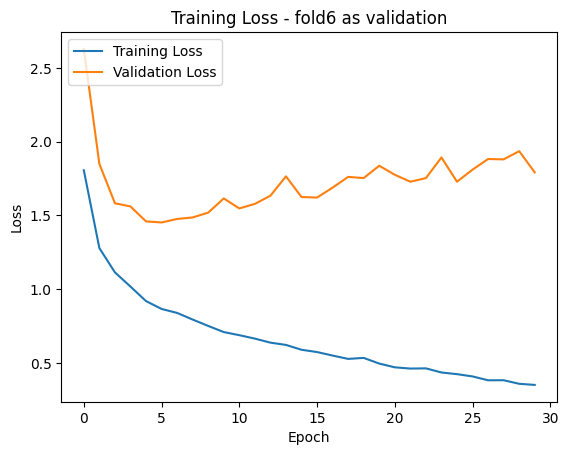

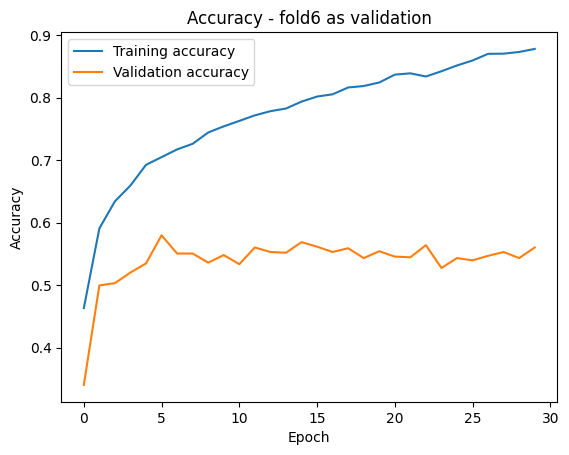

 60%|██████    | 6/10 [12:37<07:43, 115.81s/it]

Training using fold7 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.22504, saving model to model.h5
61/61 - 16s - loss: 1.8601 - accuracy: 0.4574 - val_loss: 2.2250 - val_accuracy: 0.3807 - lr: 0.0010 - 16s/epoch - 269ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.22504 to 1.66380, saving model to model.h5
61/61 - 4s - loss: 1.3027 - accuracy: 0.5895 - val_loss: 1.6638 - val_accuracy: 0.4642 - lr: 0.0010 - 4s/epoch - 70ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.66380 to 1.55346, saving model to model.h5
61/61 - 3s - loss: 1.1085 - accuracy: 0.6375 - val_loss: 1.5535 - val_accuracy: 0.4606 - lr: 0.0010 - 3s/epoch - 47ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.55346 to 1.40394, saving model to model.h5
61/61 - 3s - loss: 1.0292 - accuracy: 0.6585 - val_loss: 1.4039 - val_accuracy: 0.5155 - lr: 0.0010 - 3s/epoch - 46ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.40394 to 1.39377, saving model to model.h5
61/61 - 3s - loss: 0.9408 - a

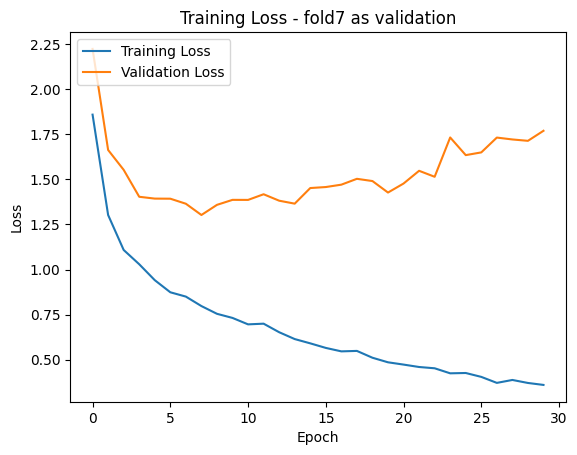

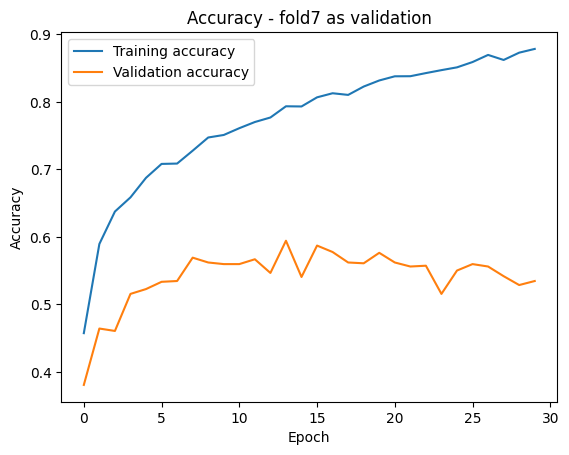

 70%|███████   | 7/10 [15:22<06:35, 131.85s/it]

Training using fold8 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.41216, saving model to model.h5
61/61 - 14s - loss: 1.7950 - accuracy: 0.4714 - val_loss: 2.4122 - val_accuracy: 0.3474 - lr: 0.0010 - 14s/epoch - 237ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.41216 to 1.87310, saving model to model.h5
61/61 - 4s - loss: 1.2882 - accuracy: 0.5889 - val_loss: 1.8731 - val_accuracy: 0.4181 - lr: 0.0010 - 4s/epoch - 67ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.87310 to 1.59203, saving model to model.h5
61/61 - 3s - loss: 1.1336 - accuracy: 0.6300 - val_loss: 1.5920 - val_accuracy: 0.5310 - lr: 0.0010 - 3s/epoch - 48ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.59203 to 1.46821, saving model to model.h5
61/61 - 4s - loss: 1.0422 - accuracy: 0.6581 - val_loss: 1.4682 - val_accuracy: 0.5025 - lr: 0.0010 - 4s/epoch - 67ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.46821 to 1.42539, saving model to model.h5
61/61 - 4s - loss: 0.9318 - a

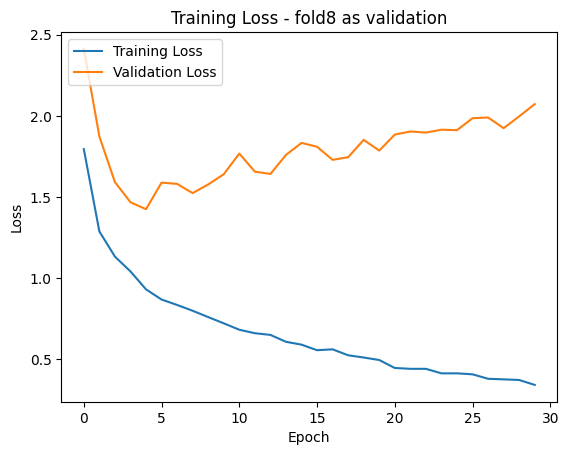

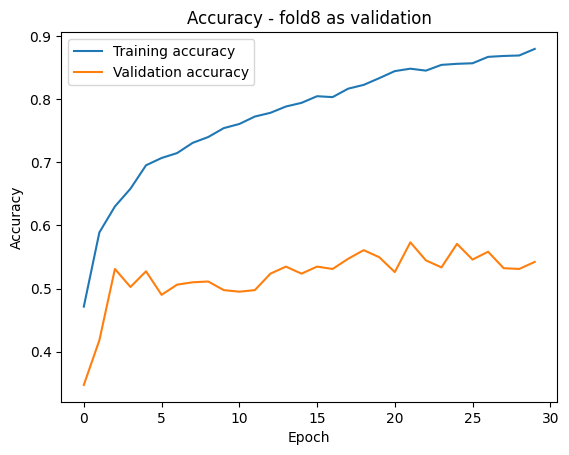

 80%|████████  | 8/10 [17:05<04:05, 122.79s/it]

Training using fold9 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 1.96873, saving model to model.h5
61/61 - 16s - loss: 1.8301 - accuracy: 0.4609 - val_loss: 1.9687 - val_accuracy: 0.5012 - lr: 0.0010 - 16s/epoch - 258ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.96873 to 1.45863, saving model to model.h5
61/61 - 5s - loss: 1.3587 - accuracy: 0.5741 - val_loss: 1.4586 - val_accuracy: 0.5809 - lr: 0.0010 - 5s/epoch - 76ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.45863 to 1.16859, saving model to model.h5
61/61 - 3s - loss: 1.1466 - accuracy: 0.6269 - val_loss: 1.1686 - val_accuracy: 0.6397 - lr: 0.0010 - 3s/epoch - 47ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.16859
61/61 - 2s - loss: 1.0422 - accuracy: 0.6524 - val_loss: 1.1718 - val_accuracy: 0.6446 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.16859 to 1.14468, saving model to model.h5
61/61 - 3s - loss: 0.9591 - accuracy: 0.6819 - val_loss: 1.

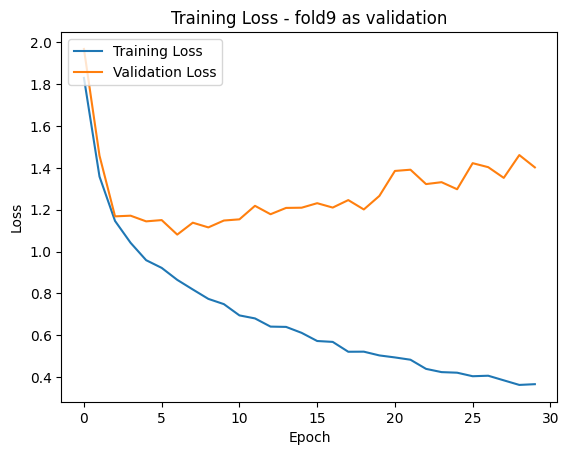

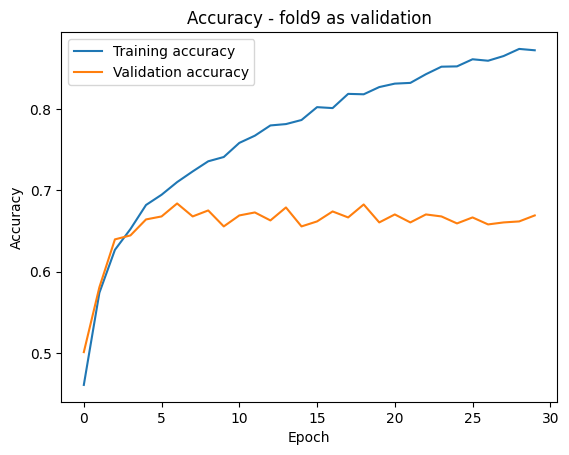

 90%|█████████ | 9/10 [18:51<01:57, 117.60s/it]

Training using fold10 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.42827, saving model to model.h5
61/61 - 15s - loss: 1.8402 - accuracy: 0.4675 - val_loss: 2.4283 - val_accuracy: 0.3668 - lr: 0.0010 - 15s/epoch - 244ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.42827 to 1.52494, saving model to model.h5
61/61 - 4s - loss: 1.2663 - accuracy: 0.5952 - val_loss: 1.5249 - val_accuracy: 0.4922 - lr: 0.0010 - 4s/epoch - 73ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.52494 to 1.41927, saving model to model.h5
61/61 - 3s - loss: 1.1327 - accuracy: 0.6356 - val_loss: 1.4193 - val_accuracy: 0.5137 - lr: 0.0010 - 3s/epoch - 54ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.41927 to 1.27591, saving model to model.h5
61/61 - 3s - loss: 1.0431 - accuracy: 0.6561 - val_loss: 1.2759 - val_accuracy: 0.5926 - lr: 0.0010 - 3s/epoch - 51ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.27591 to 1.22953, saving model to model.h5
61/61 - 4s - loss: 0.9515 - 

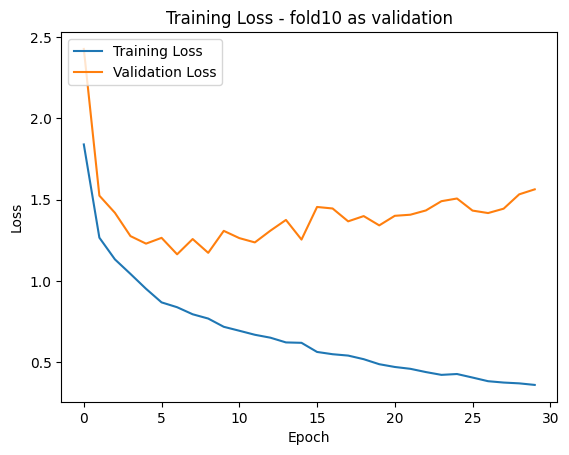

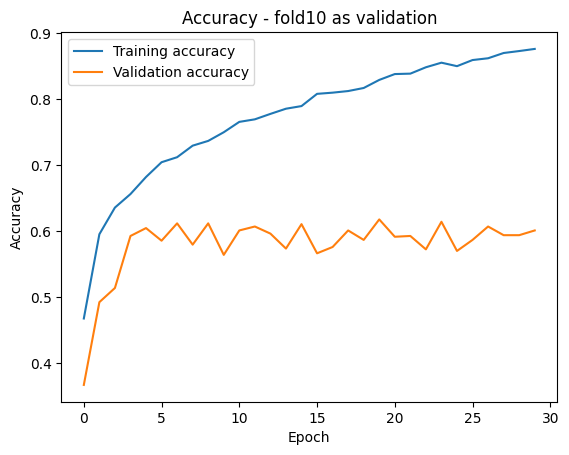

100%|██████████| 10/10 [21:38<00:00, 129.81s/it]


List of scores[0.5452463030815125, 0.5382882952690125, 0.4583783745765686, 0.5, 0.5876068472862244, 0.5601457953453064, 0.5346062183380127, 0.5421836376190186, 0.6691176295280457, 0.6009557843208313]
Average accuracy: 0.5536528885364532 with standard deviation 0.054333806917600154
Trained only the last -8 layers


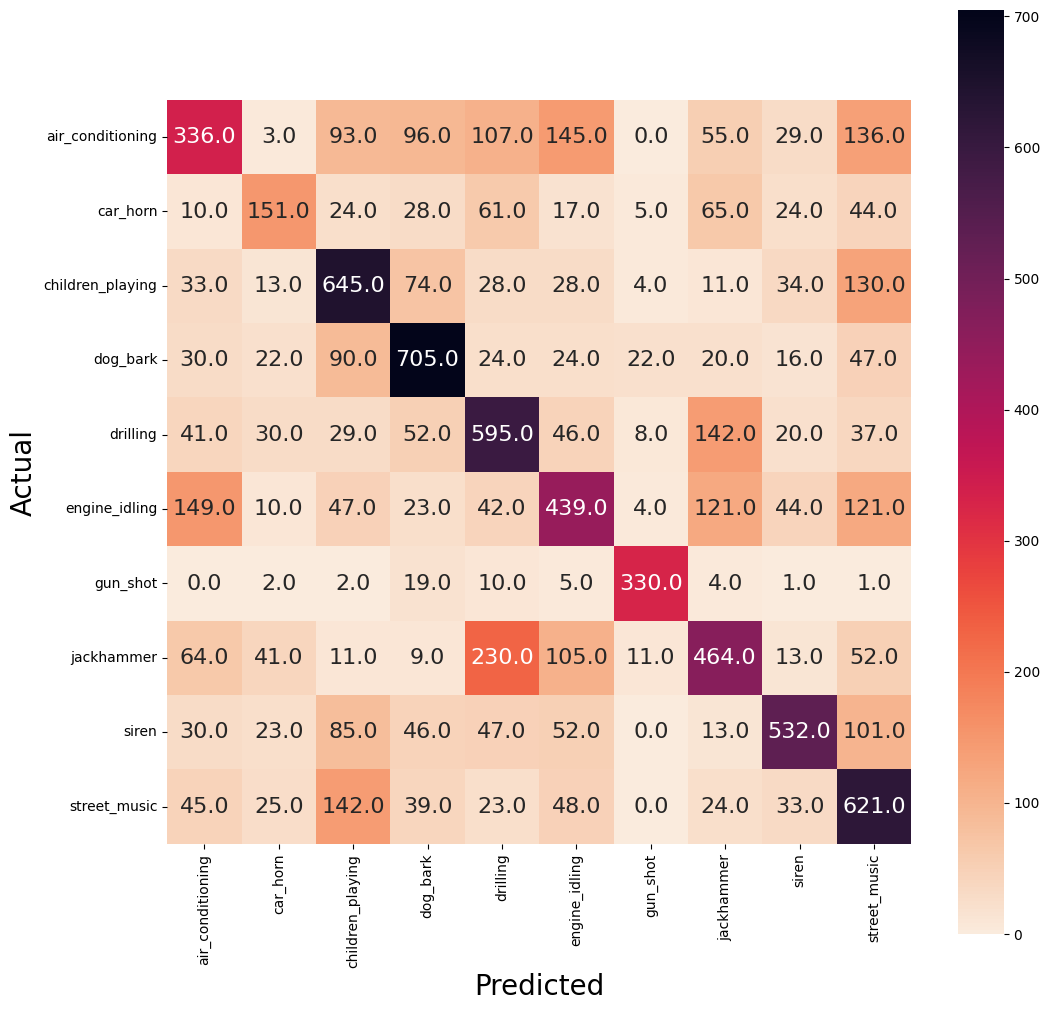

In [9]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 128

#We turned off early stopping for the sake of plotting
early_stop = 100 # early stoppping after 3 epochs with no improvement of test data

trainable_layers = -8 #trainable layers needs a minus infront
dropout_rate = 0.5
learning_rate = 0.001


def model_k_cross(data):
    list_scores = []
    Ytrue_list = []
    Ypred_list = []
    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()

        #Densenet121 model using pretrained weights from imagenet
        model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

        x=model_d.output
        x= GlobalAveragePooling2D()(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(1024,activation='relu')(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(512,activation='relu')(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(256,activation='relu')(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        preds=Dense(10,activation='softmax')(x) #FC-layer
        model=Model(inputs=model_d.input,outputs=preds)

        #instance of Adam optimizer
        Adam = keras.optimizers.Adam(learning_rate=learning_rate)


        #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
        for layer in model.layers[:trainable_layers]:
            layer.trainable=False
        for layer in model.layers[trainable_layers:]:
            layer.trainable=True


        #Splitting data
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)



        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


        history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])

        #Storing values
        Ypred_it = model.predict(X_val)
        Ypred_it = np.argmax(Ypred_it, axis=1)
        Ytrue_it = np.argmax(y_val, axis=1)
        Ytrue_list.extend(Ytrue_it.tolist())  # Append predictions to lists
        Ypred_list.extend(Ypred_it.tolist())


        # Plot training history - loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    list_scores_array = np.array(list_scores)
    std = np.std(list_scores_array)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc} with standard deviation {std}')
    print(f'Trained only the last {trainable_layers} layers')
    Ytrue = np.array(Ytrue_list)
    Ypred = np.array(Ypred_list)

    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    #Confusion matrix
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)


model_k_cross(data)